Erzeugt Graphen aus game_patterns Objekten.

In [1]:

import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


%run ./REST.ipynb
%run ./GamePatterns.ipynb

%run ./DistanceCalculator.ipynb
%matplotlib inline


Parameter

In [2]:


maximum_edge_size = 3
node_size=1000
node_color='blue'
edge_color='#303060A0'
font_size =20
alpha=0.5
title_size = 20



output_directory = "Output/Graphs"
filename_prefix = "Graph-"


export_graph = True



single_mode = False
#nur für single_mode = False
input_directory = "Output/GamePattern"
#nur für single_mode = True
game_pattern_file = ""

distance_threshold = 0
distance_fkt = distance_minimum
#distance_fkt = distance_average
#distance_fkt = distance_hausdorff
#distance_fkt = distance_cuddle



Pattern Namen laden

In [3]:
client = empamos_rest_client()

pattern_names = client.get_patterns_name_dictionary()
pattern_names

{1292: 'Zufall',
 1409: 'Wählbarer Schwierigkeitsgrad',
 1417: 'Angemessener Schwierigkeitsgrad',
 1433: 'Spielvarianten',
 1446: 'Zeitlimit',
 1455: 'Zug um Zug',
 1464: 'Informationsasymmetrie',
 1473: 'Spielendbedingung',
 1482: 'Sammeln',
 1492: 'Siegbedingung',
 1515: 'Ausholen',
 1665: 'Spielform',
 1756: 'Zwischenstand',
 2884: 'Tausch',
 2894: 'Ressourcen',
 2907: 'Veränderliches Spielfeld',
 2968: 'Ereignis',
 2981: 'Rolle',
 3085: 'Währung',
 3098: 'Belohnung',
 3142: 'Verlierbedingung',
 3173: 'Gemeinsames Spielfeld',
 3194: 'Avatar',
 3285: 'Feedback',
 3312: 'Punkte',
 3377: 'Aussetzen',
 3755: 'Unveränderliches Spielfeld',
 4426: 'Zugplanungserfordernis',
 5718: 'Gambling',
 5729: 'Erinnern',
 5740: 'Joker',
 7090: 'Kooperative Spielform',
 7098: 'Koordinierte Spielform',
 7106: 'Konfliktäre Spielform',
 7115: 'Kompetitive Spielform',
 7123: 'Team',
 7227: 'Negatives Ereignis',
 8520: 'Modifizierter Zufall',
 8528: 'Siegpunkte',
 8536: 'Aktionspunkte',
 8544: 'Handel',
 8

In [4]:
if(single_mode):
    game_pattern_files = [game_pattern_file]
else:
    game_pattern_files = [join(input_directory, f) for f in listdir(input_directory) if isfile(join(input_directory, f))]

os.makedirs(output_directory, exist_ok=True)

['Output/GamePattern/GamePatterns-8a88843df659fcada89c9ff24f55aaf9.json', 'Output/GamePattern/GamePatterns-46a0e7d814e78b2978f6c703fefefabd.json', 'Output/GamePattern/GamePatterns-d813d522bf7223f65291298b47cccfc0.json', 'Output/GamePattern/GamePatterns-3e7a4f1fb27c9cbf01a868ad0e837eb6.json', 'Output/GamePattern/GamePatterns-734cd9c7261e22d23bebf114c2e351d9.json']


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


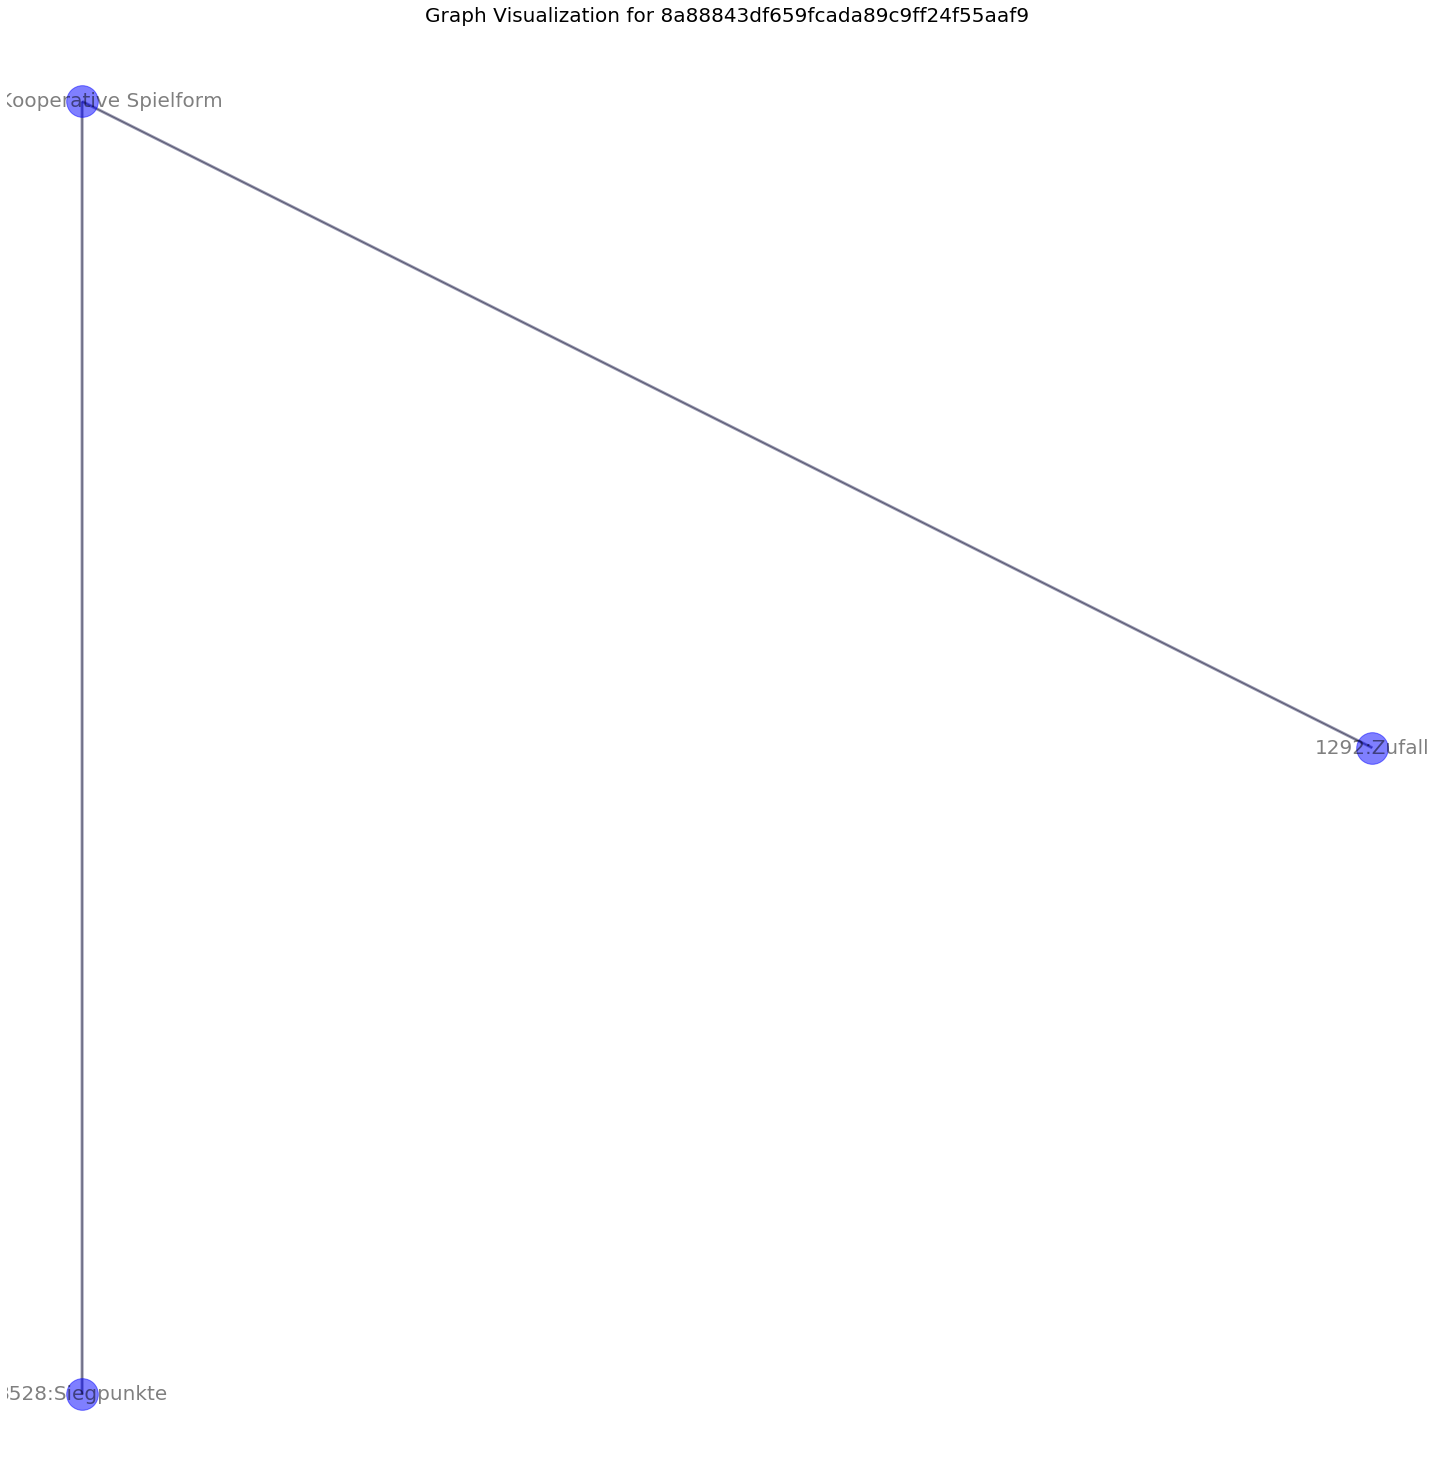

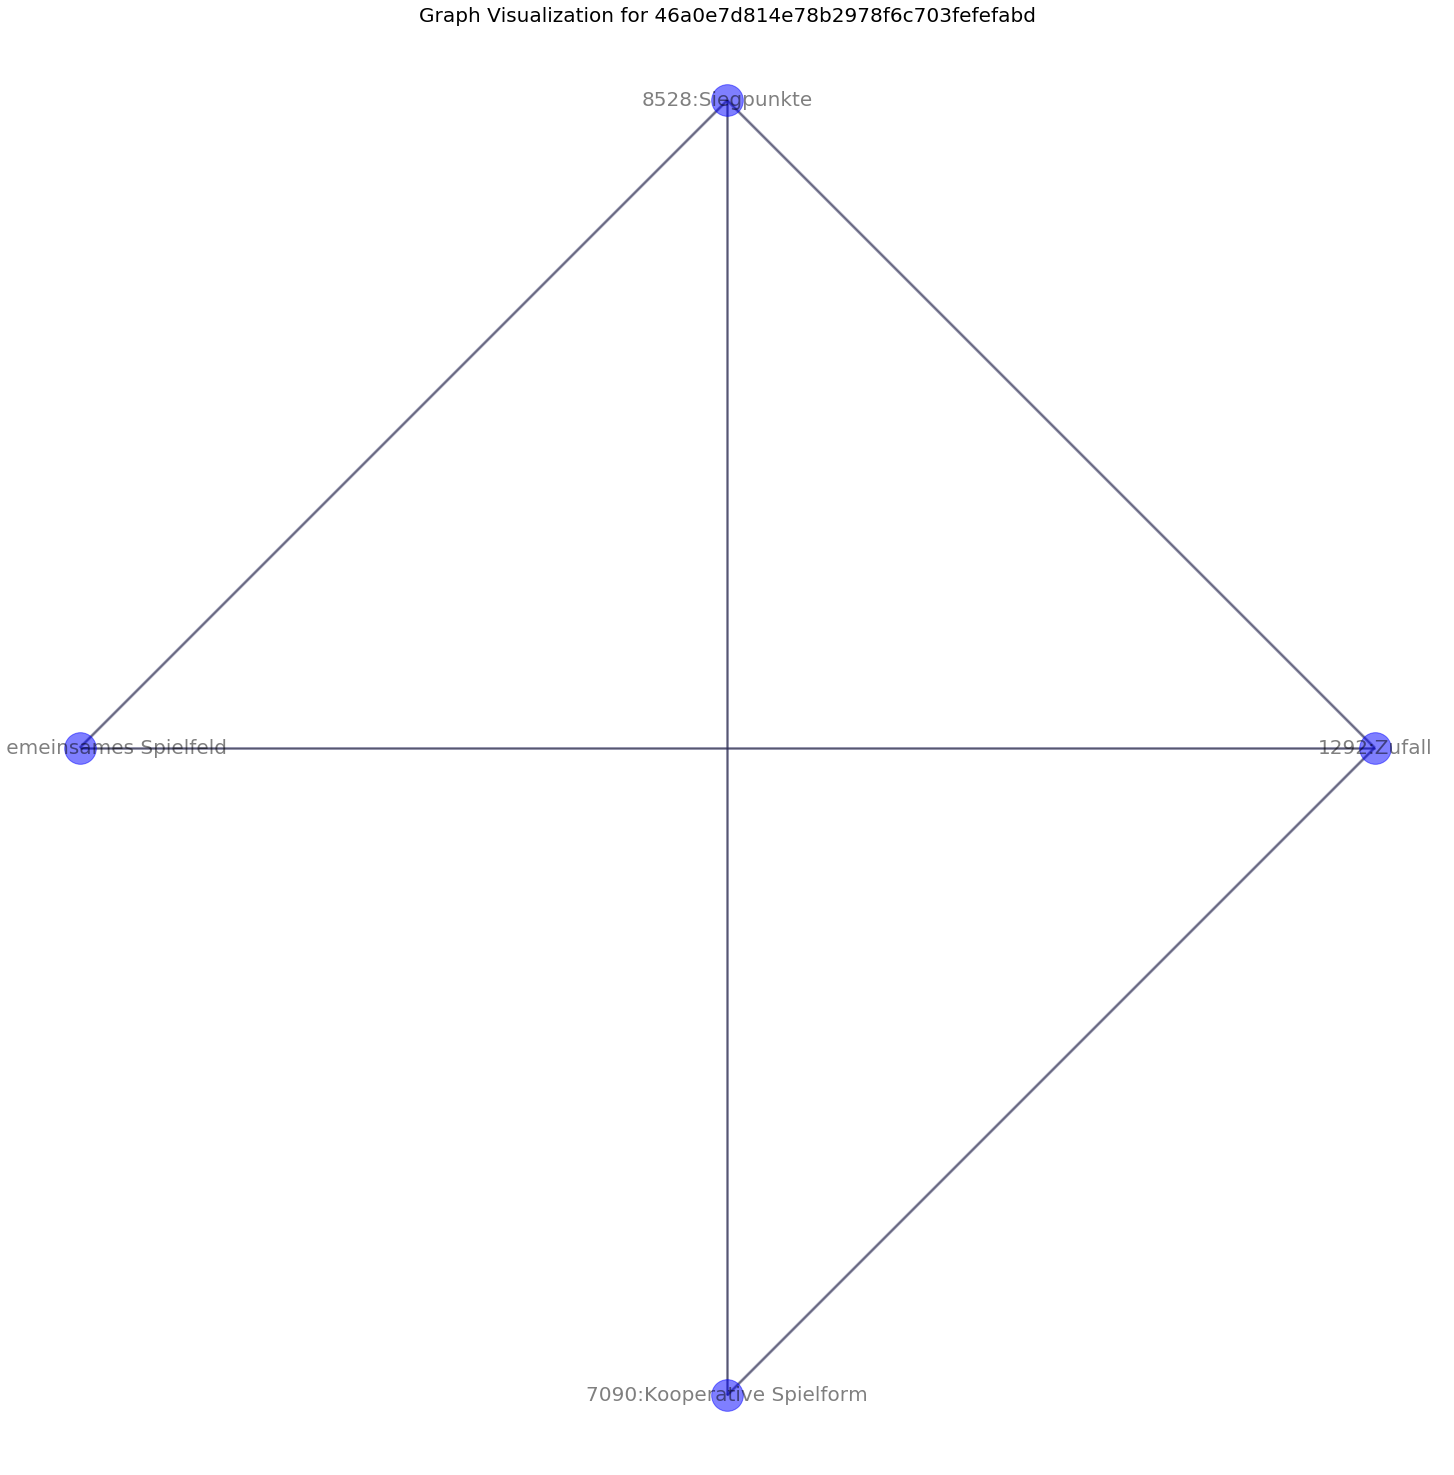

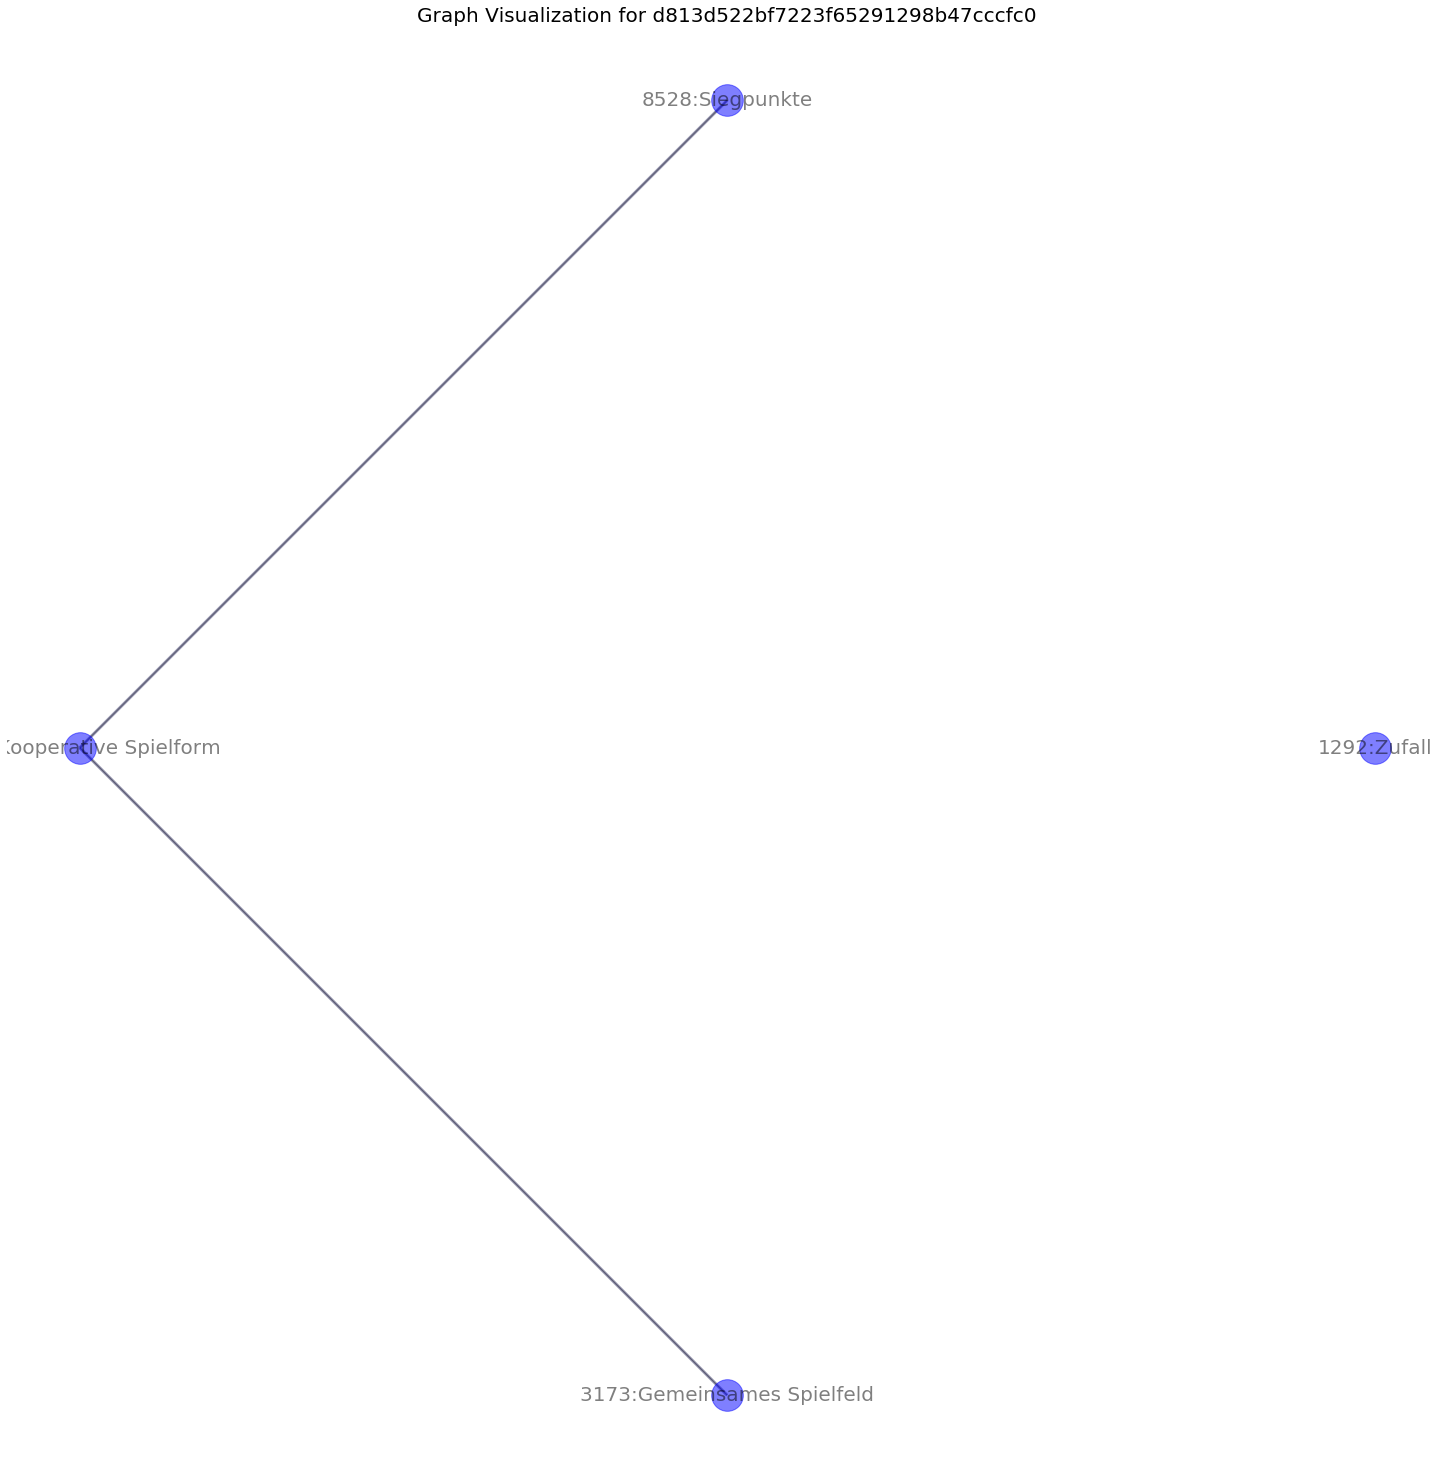

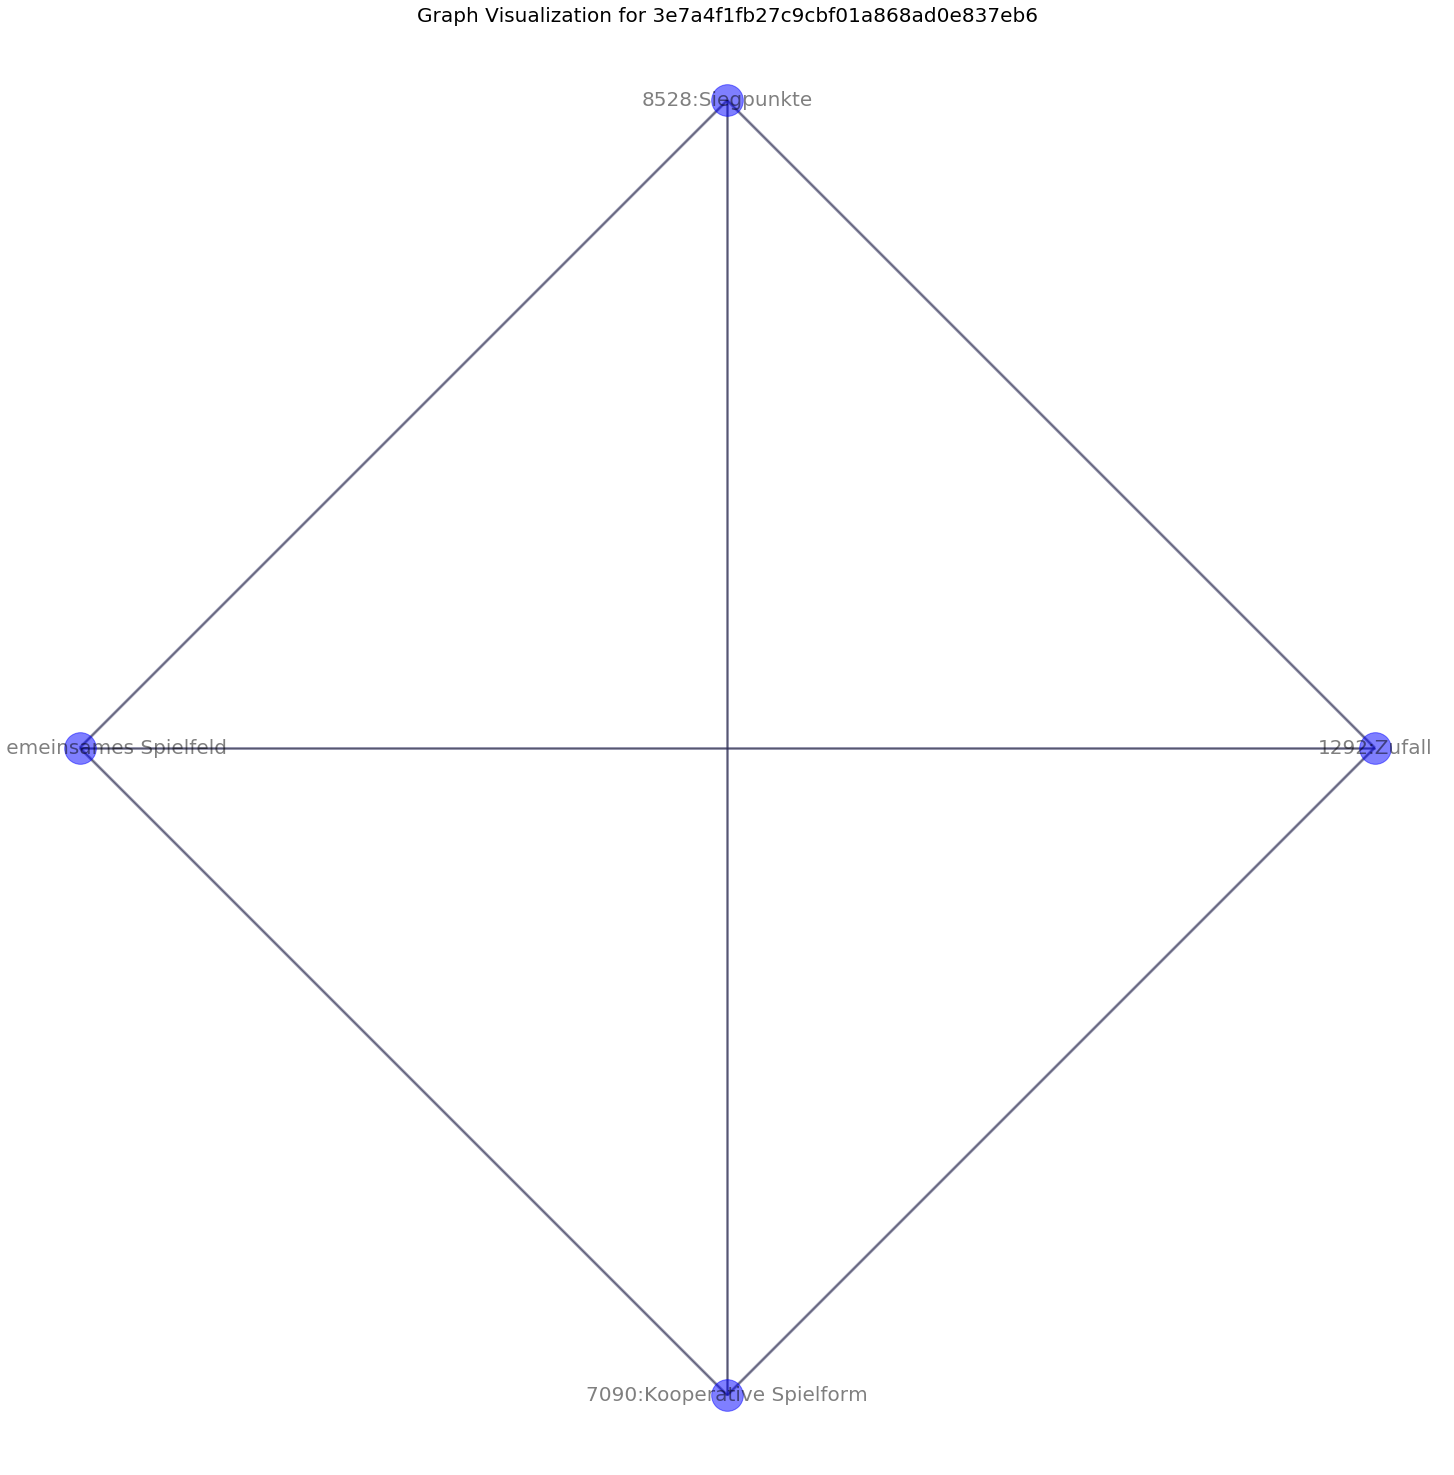

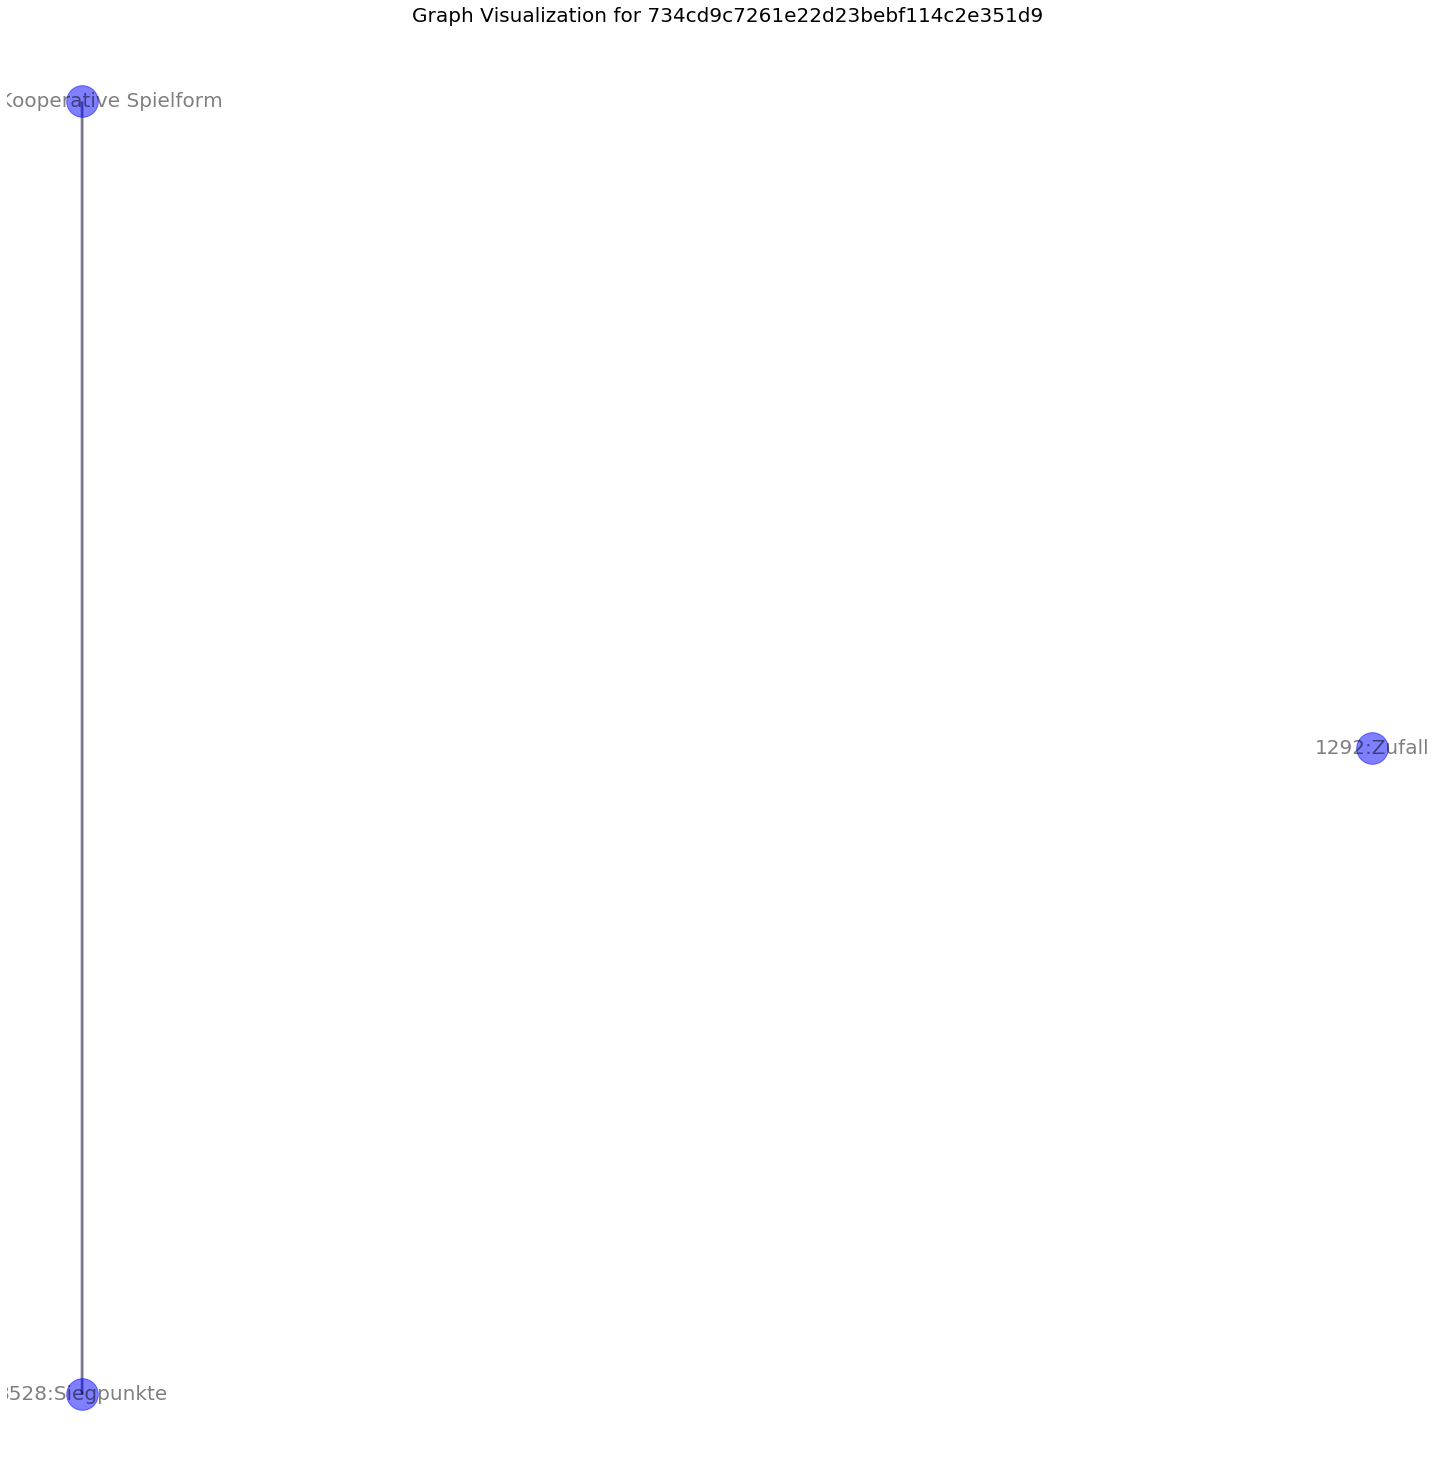

In [7]:
for game_pattern_file in game_pattern_files:
    
    try:
        with open(game_pattern_file,"r") as f:
            gpjson = json.loads(f.read())
        gp = game_patterns(**gpjson)
    except:
        print("Fehler beim Initialisieren! " + game_pattern_file)
        continue

 
    dists = calculate_distance(gp.patterns,distance_fkt)
    
    df = pd.DataFrame(columns=['source', 'target', 'value'])
    for i in range(0,len(gp.patterns)):
        for j in range (i,len(gp.patterns)):
            d = dists[list(gp.patterns.keys())[i]][list(gp.patterns.keys())[j]] 
            if d <= distance_threshold or i ==j:    
                value = maximum_edge_size * (distance_threshold +0.01 - d) / (distance_threshold +0.01)
                s = list(gp.patterns.keys())[i]
                t = list(gp.patterns.keys())[j]
                new_row = {'source':str(s)+":"+pattern_names[s], 'target':str(t)+":"+pattern_names[t], 'value':value}
                df = df.append(new_row, ignore_index=True)
    # Build your graph
    G = nx.from_pandas_edgelist(df, 
                                source='source',
                                target='target',
                                edge_attr=True)
    
    #Write the Graph in a file
    if export_graph:
        nx.write_graphml(G,output_directory+"/"+ filename_prefix + str(gp.get_ID()) + ".graphml")
        
    #pos = nx.kamada_kawai_layout(G, weight='value')
    pos = nx.circular_layout(G)
    _ = plt.figure(figsize=(20, 20))
    nx.draw(G, pos, 
            node_size=node_size, 
            node_color=node_color,
            font_size =font_size,
            alpha=alpha,
            with_labels = True)
    plt.title('Graph Visualization for ' + str(gp.get_ID()), size=title_size)

    for (node1,node2,data) in G.edges(data=True):
        width = data['value'] 
        _ = nx.draw_networkx_edges(G,pos,
                                   edgelist=[(node1, node2)],
                                   width=width,
                                   edge_color=edge_color,
                                   alpha=0.5)

    plt.show()